In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
from tqdm import tqdm

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [7]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType, StringType
from pyspark import broadcast


import emoji

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

spark = SparkSession.builder \
    .master('local') \
    .appName('BigData-HW') \
    .config('spark.executor.memory', '16gb') \
    .config("spark.cores.max", "8") \
    .getOrCreate()

In [3]:
!ls

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [45]:
stats = spark.read.csv('profiles.csv', header=True)

cast_fields = ['followedby','follow','postscount','post_0_comments','post_0_likes']

for field in cast_fields:
    stats = stats.withColumn(field, stats[field].cast("double"))

stats.limit(1).show()
stats.dtypes
#stats = pd.read_csv("profiles.csv", index_col=0)
#stats.head()

+---+--------------------+----------+-----------+----------+------+----------+---------------+------------+---------------+------------+---------------+------------+---------------+------------+---------------+------------+---------------+------------+---------------+------------+---------------+------------+---------------+------------+---------------+------------+
|_c0|                 _id|        id|   username|followedby|follow|postscount|post_0_comments|post_0_likes|post_1_comments|post_1_likes|post_2_comments|post_2_likes|post_3_comments|post_3_likes|post_4_comments|post_4_likes|post_5_comments|post_5_likes|post_6_comments|post_6_likes|post_7_comments|post_7_likes|post_8_comments|post_8_likes|post_9_comments|post_9_likes|
+---+--------------------+----------+-----------+----------+------+----------+---------------+------------+---------------+------------+---------------+------------+---------------+------------+---------------+------------+---------------+------------+----------

[('_c0', 'string'),
 ('_id', 'string'),
 ('id', 'string'),
 ('username', 'string'),
 ('followedby', 'double'),
 ('follow', 'double'),
 ('postscount', 'double'),
 ('post_0_comments', 'double'),
 ('post_0_likes', 'double'),
 ('post_1_comments', 'string'),
 ('post_1_likes', 'string'),
 ('post_2_comments', 'string'),
 ('post_2_likes', 'string'),
 ('post_3_comments', 'string'),
 ('post_3_likes', 'string'),
 ('post_4_comments', 'string'),
 ('post_4_likes', 'string'),
 ('post_5_comments', 'string'),
 ('post_5_likes', 'string'),
 ('post_6_comments', 'string'),
 ('post_6_likes', 'string'),
 ('post_7_comments', 'string'),
 ('post_7_likes', 'string'),
 ('post_8_comments', 'string'),
 ('post_8_likes', 'string'),
 ('post_9_comments', 'string'),
 ('post_9_likes', 'string')]

In [27]:
stats.describe()

DataFrame[summary: string, _c0: string, _id: string, id: string, username: string, followedby: string, follow: string, postscount: string, post_0_comments: string, post_0_likes: string, post_1_comments: string, post_1_likes: string, post_2_comments: string, post_2_likes: string, post_3_comments: string, post_3_likes: string, post_4_comments: string, post_4_likes: string, post_5_comments: string, post_5_likes: string, post_6_comments: string, post_6_likes: string, post_7_comments: string, post_7_likes: string, post_8_comments: string, post_8_likes: string, post_9_comments: string, post_9_likes: string]

In [46]:
def filter_outliers(df, columns, q_min=0.01, q_max=0.99):
    
    for column in columns:
        [q_low, q_hi] = df.approxQuantile(column, [0.01, 0.99], 0.01)
        df = df.filter((df[field] > q_low) & (df[field] < q_hi))
    
    return df

everything = ['followedby', 'follow', 'postscount']


stats.count()
stats = filter_outliers(stats, everything)
stats.count()

111960

103953

# Get sampled dataset for pandas-seaborn visualization

In [56]:
full_size = stats.count()
sampled_size = 10000
sampling_ratio = sampled_size / full_size



sampled_df = stats.sample(False, sampling_ratio, 12345)
sampled_df.count()
pd_sampled_df = sampled_df.select("*").toPandas()

9957

,followedby,follow,postscount,post_0_comments,post_0_likes
count,9.957000e+03,9957.000000,9957.000000,9957.000000,9957.000000
mean,2.260955e+03,499.666868,367.574972,5.598976,74.600683
std,1.811609e+04,884.811747,874.378449,111.095324,473.339874
min,1.000000e+00,0.000000,1.000000,0.000000,2.000000
25%,1.570000e+02,120.000000,47.000000,0.000000,16.000000
50%,3.860000e+02,253.000000,145.000000,1.000000,34.000000
75%,9.060000e+02,494.000000,417.000000,4.000000,68.000000
max,1.149729e+06,7504.000000,46694.000000,9344.000000,31764.000000


In [62]:
from pyspark.sql.functions import col
log_features = ['followedby', 'follow', 'postscount']

for feature in log_features:
    stats = stats.withColumn(feature + "_log", log10(col(feature) + 1))

In [77]:

mean_matrix = stats.agg(avg(col("followedby_log")).alias('mean_followedby_log'),
          avg(col("follow_log")).alias('mean_follow_log'),
          avg(col("postscount_log")).alias('mean_postscount_log')).select("*").toPandas()

mean_matrix

,mean_followedby_log,mean_follow_log,mean_postscount_log
0,2.619377,2.357787,2.138133


In [75]:
log_features = ['followedby_log', 'follow_log', 'postscount_log']

cov_matrix = pd.DataFrame()
for i in log_features:
    cov_row = []
    for j in log_features:
        cov_row.append(stats.cov(i,j))
    cov_matrix = cov_matrix.append(pd.DataFrame([cov_row]))

cov_matrix

,0,1,2
0,0.420743,0.163132,0.228100
0,0.163132,0.344208,0.140350
0,0.228100,0.140350,0.427446


In [6]:
DISTRIBUTIONS = [        
    st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
    st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
    st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
    st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
    st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
    st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,
    st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
    st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
    st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
    st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
]

def rank_distribution_fitness(data: np.array, bins=50) -> list:
    
    fitness_results = list()
    
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    # Estimate distribution parameters from data
    for distribution in tqdm(DISTRIBUTIONS):

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                fitness_results.append((sse, distribution, params))

        except Exception as e:
            print(e)
        
    fitness_results.sort(key=lambda x: x[0])

    return fitness_results

def make_pdf(dist, params, size=10000) -> pd.Series:
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

def print_best(distribs, ax, data, bins=50):
    
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    pos = 0
    for _, distribution, params in distribs:
        pos += 1
        if pos >= 6:
            return
        
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
        
         # if axis pass in add to plot
        try:
            if ax:
                pd.Series(pdf, x).plot(ax=ax)
            end
        except Exception:
            pass

## filter strong outliers

In [7]:
stats.columns

Index(['_id', 'id', 'username', 'followedby', 'follow', 'postscount',
       'post_0_comments', 'post_0_likes', 'post_1_comments', 'post_1_likes',
       'post_2_comments', 'post_2_likes', 'post_3_comments', 'post_3_likes',
       'post_4_comments', 'post_4_likes', 'post_5_comments', 'post_5_likes',
       'post_6_comments', 'post_6_likes', 'post_7_comments', 'post_7_likes',
       'post_8_comments', 'post_8_likes', 'post_9_comments', 'post_9_likes'],
      dtype='object')

## EDA

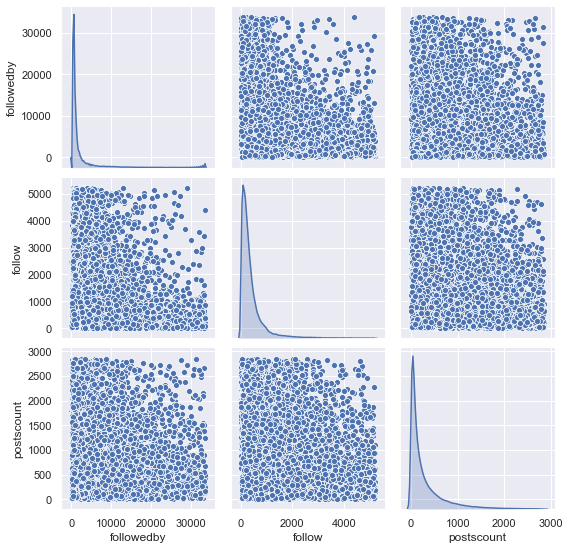

In [9]:
sns.pairplot(stats, vars=["followedby", "follow", "postscount"], diag_kind="kde");

In [10]:
sns.heatmap(stats[['followedby','follow','postscount','likes_mean','likes_median','comments_mean','comments_median']].corr(),annot=True)

KeyError: "['likes_mean', 'likes_median', 'comments_median', 'comments_mean'] not in index"

## followedby

In [11]:
stats.followedby.describe()

count    104744.000000
mean       1099.402582
std        2818.288050
min          13.000000
25%         152.000000
50%         363.000000
75%         811.000000
max       33761.000000
Name: followedby, dtype: float64

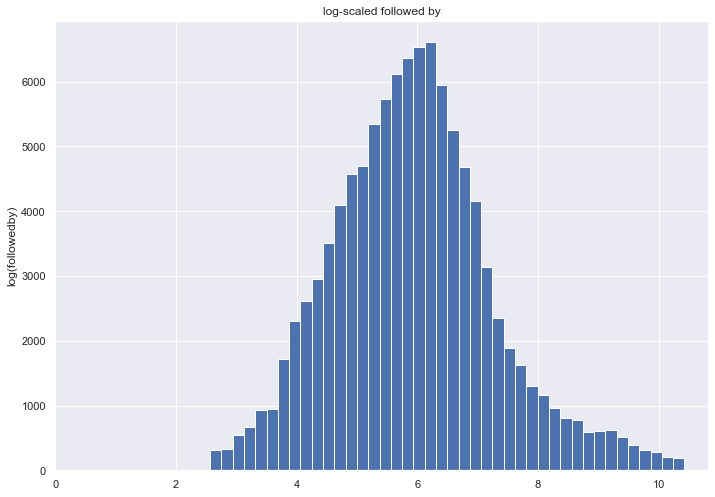

In [12]:
log_scale_followedby = np.ma.log(stats.followedby.values)
plt.hist(log_scale_followedby, bins=42)
plt.title("log-scaled followed by")
plt.xlabel('')
plt.ylabel('log(followedby)')
plt.xlim((0, None));

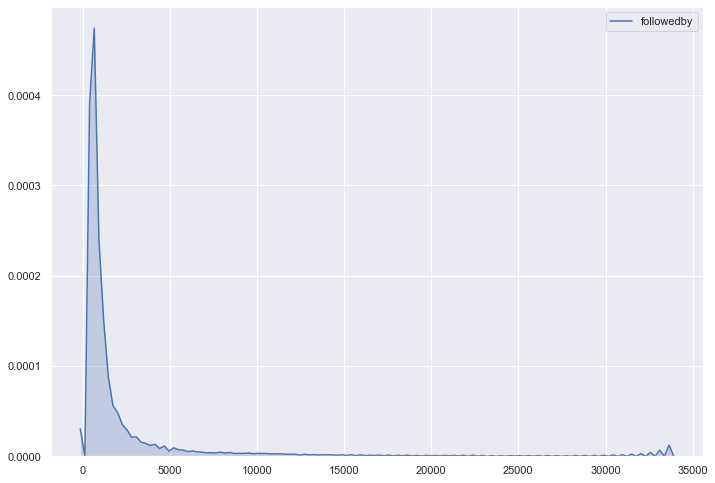

In [169]:
sns.kdeplot(stats.followedby, shade=True);

## followers

In [170]:
stats.followedby.describe()

count    104744.000000
mean       1099.402582
std        2818.288050
min          13.000000
25%         152.000000
50%         363.000000
75%         811.000000
max       33761.000000
Name: followedby, dtype: float64

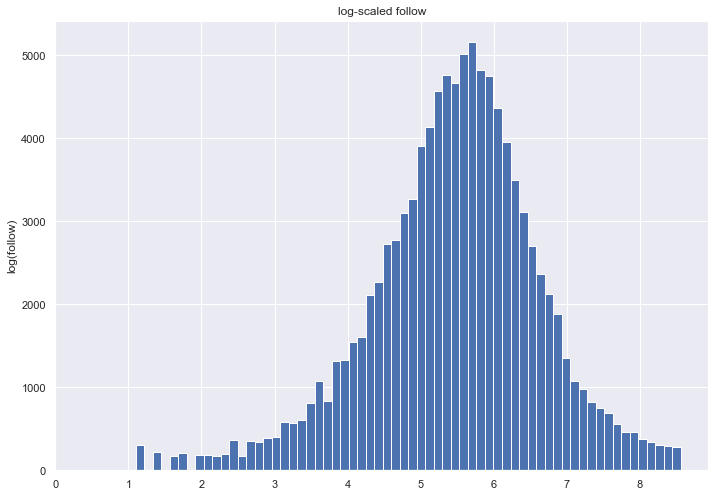

In [171]:
log_scale_follow = np.ma.log(stats.follow.values)
plt.hist(log_scale_follow, bins=64)
plt.title("log-scaled follow")
plt.xlabel('')
plt.ylabel('log(follow)')
plt.xlim((0, None));

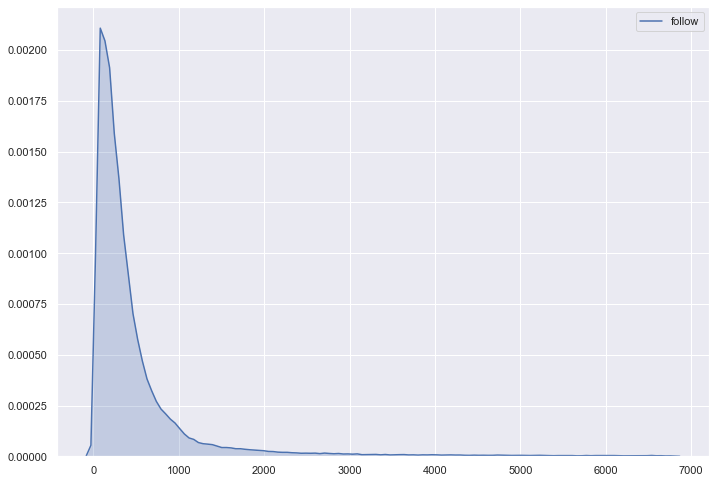

In [120]:
sns.kdeplot(stats.follow, shade=True);

## postscount

In [121]:
stats.postscount.describe()

count    108195.000000
mean        330.516604
std         491.229904
min           2.000000
25%          46.000000
50%         142.000000
75%         401.000000
max        4016.000000
Name: postscount, dtype: float64

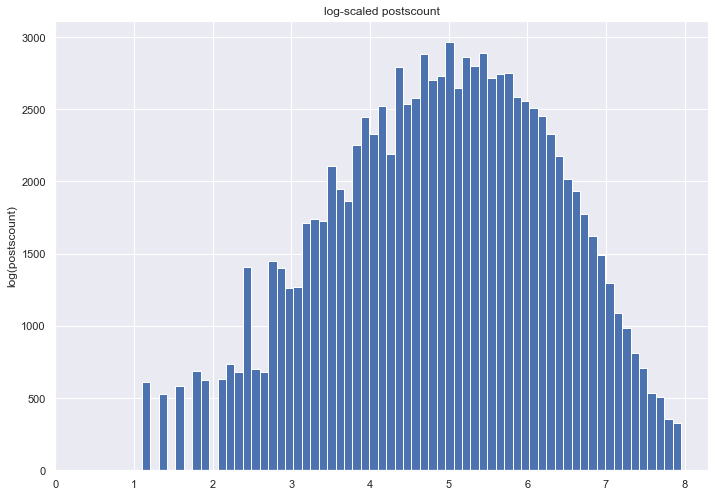

In [172]:
log_scale_postscount = np.ma.log(stats.postscount.values)
plt.hist(log_scale_postscount, bins=64)
plt.title("log-scaled postscount")
plt.xlabel('')
plt.ylabel('log(postscount)')
plt.xlim((0, None));

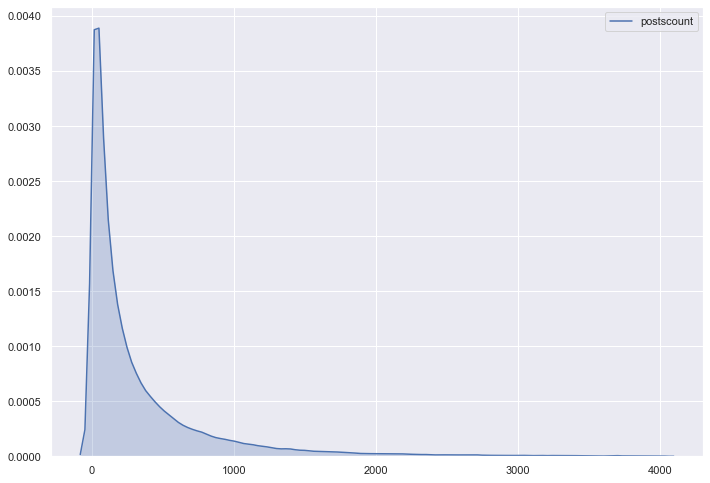

In [123]:
sns.kdeplot(stats.postscount, shade=True);

## posts

**Comments**

In [19]:
comments_cols = [f"post_{i}_comments" for i in range(10)]
stats["comments_mean"] = stats[comments_cols].apply(np.mean, axis=1)
stats["comments_median"] = stats[comments_cols].apply(np.median, axis=1)

In [20]:
stats.post_0_comments.describe()

count    104744.000000
mean          3.622718
std          38.139129
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max        6197.000000
Name: post_0_comments, dtype: float64

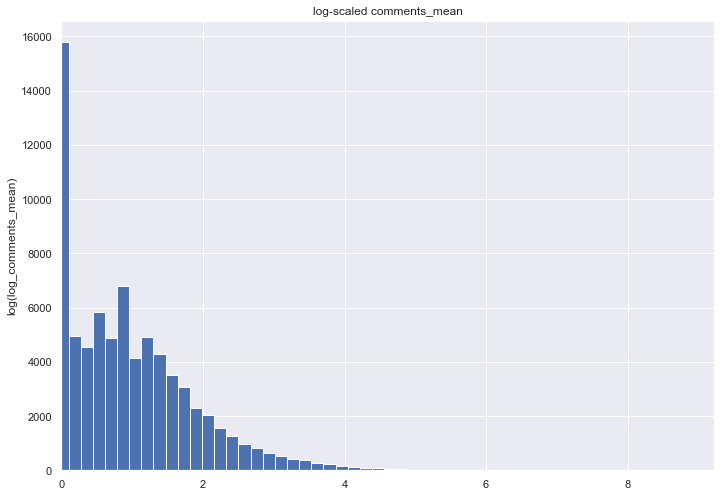

In [21]:
log_comments_mean = np.ma.log(stats.comments_mean.values)
plt.hist(log_comments_mean, bins=64)
plt.title("log-scaled comments_mean")
plt.xlabel('')
plt.ylabel('log(log_comments_mean)')
plt.xlim((0, None));

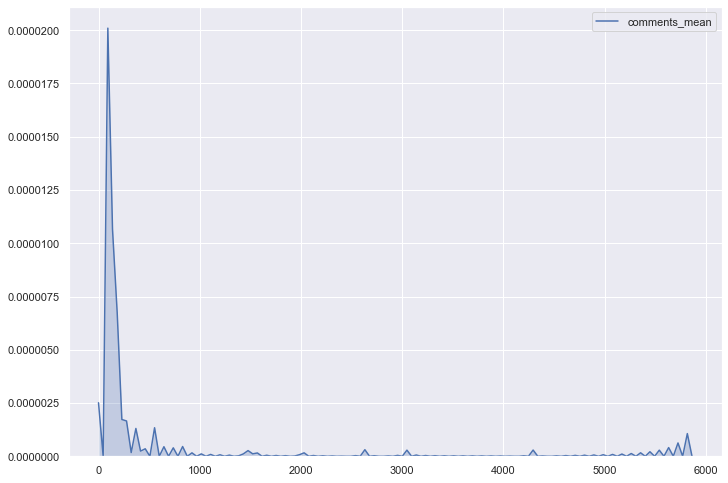

In [22]:
sns.kdeplot(stats.comments_mean, shade=True);

In [128]:
stats.comments_mean.describe()

count    108195.000000
mean          3.802642
std          29.897185
min           0.000000
25%           0.500000
50%           1.400000
75%           3.200000
max        5861.600000
Name: comments_mean, dtype: float64

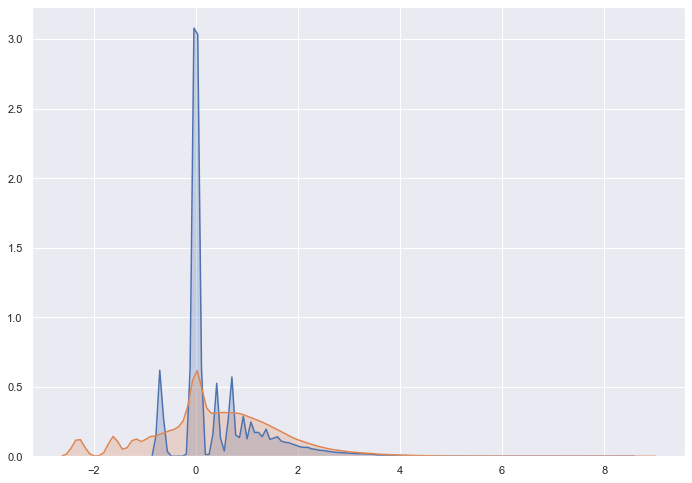

In [176]:
sns.kdeplot(np.ma.log(stats.comments_median.values), shade=True);
sns.kdeplot(np.ma.log(stats.comments_mean.values), shade=True);

**Likes**

In [253]:
likes_cols = [f"post_{i}_likes" for i in range(10)]
stats["likes_mean"] = stats[likes_cols].apply(np.mean, axis=1)
stats["likes_median"] = stats[likes_cols].apply(np.mean, axis=1)

(5044, 30)

In [24]:
stats.post_0_likes.describe()

count    104744.000000
mean         55.011743
std         200.142405
min           0.000000
25%          14.000000
50%          31.000000
75%          63.000000
max       52099.000000
Name: post_0_likes, dtype: float64

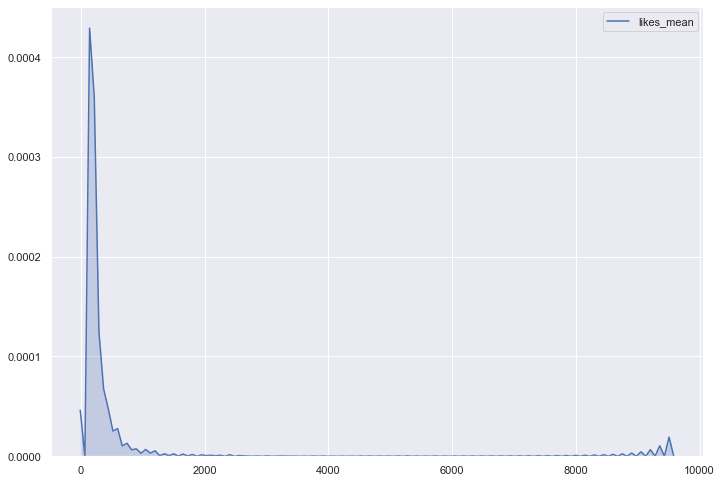

In [25]:
sns.kdeplot(stats.likes_mean, shade=True);

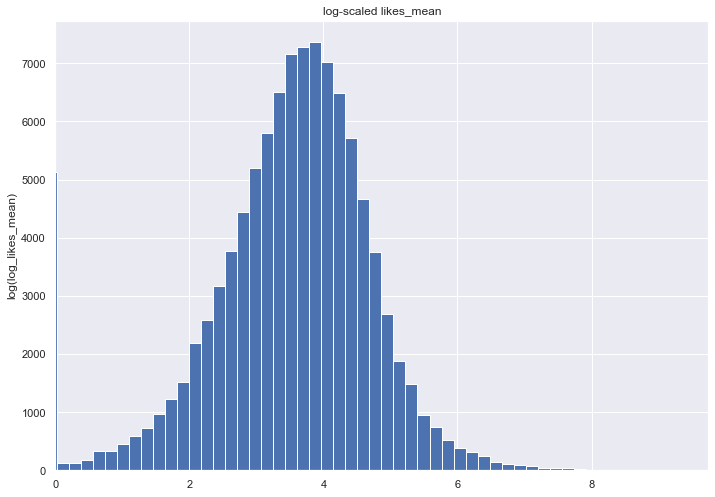

In [26]:
log_likes_mean = np.ma.log(stats.likes_mean.values)
plt.hist(log_likes_mean, bins=64)
plt.title("log-scaled likes_mean")
plt.xlabel('')
plt.ylabel('log(log_likes_mean)')
plt.xlim((0, None));

In [27]:
stats.post_0_likes.describe()

count    104744.000000
mean         55.011743
std         200.142405
min           0.000000
25%          14.000000
50%          31.000000
75%          63.000000
max       52099.000000
Name: post_0_likes, dtype: float64

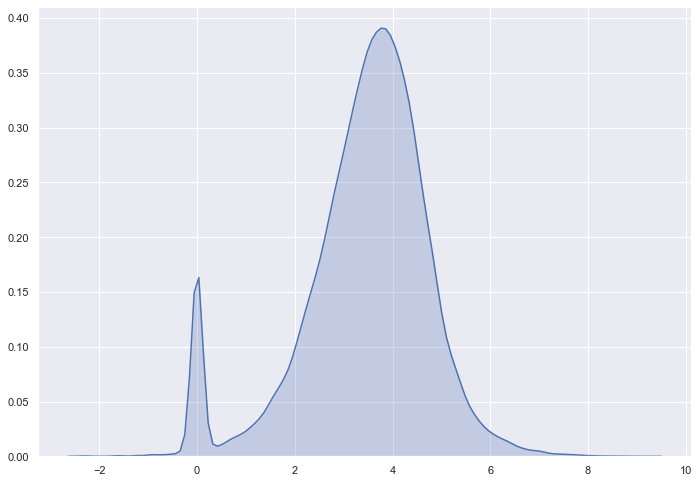

In [141]:
sns.kdeplot(np.ma.log(stats.likes_mean.values), shade=True);

**Distributions likes for every posts regardless of profile**

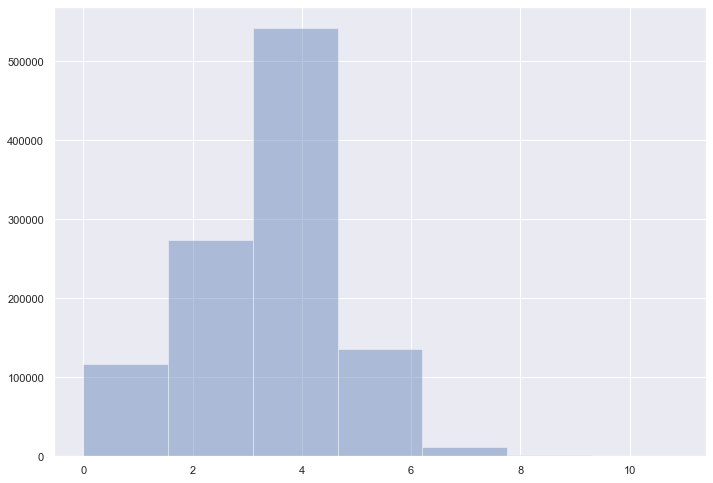

In [136]:
sns.distplot(np.ma.log(stats[likes_cols].values.reshape(-1, 1)), kde=False, bins=7);

**Distributions of likes for the same profile**

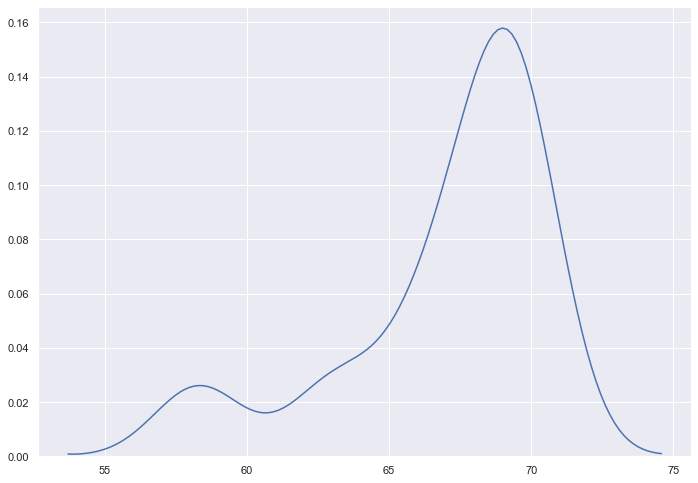

In [137]:
sns.kdeplot(stats[likes_cols].apply(np.mean, axis=0).values.T);

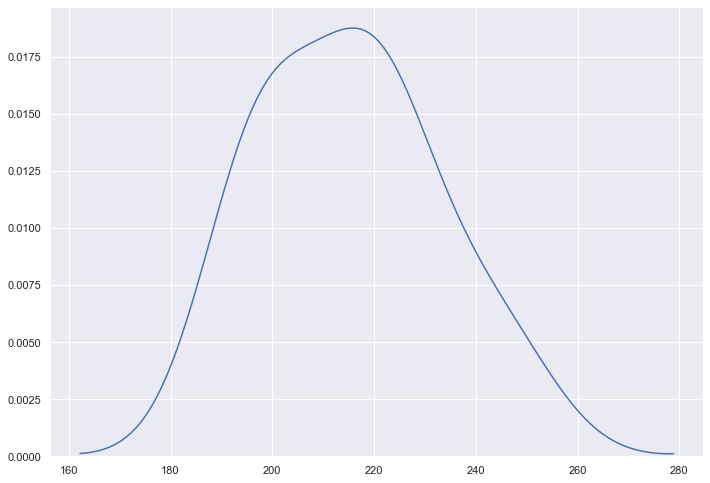

In [138]:
sns.kdeplot(stats[likes_cols].apply(np.std, axis=0).values.T);

## Joint distributions

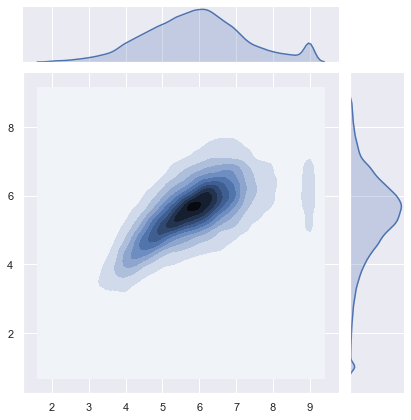

In [139]:
sns.jointplot(
    np.clip(log_scale_followedby, 2, 9), 
    np.clip(log_scale_follow, 1, 9),
    kind="kde");

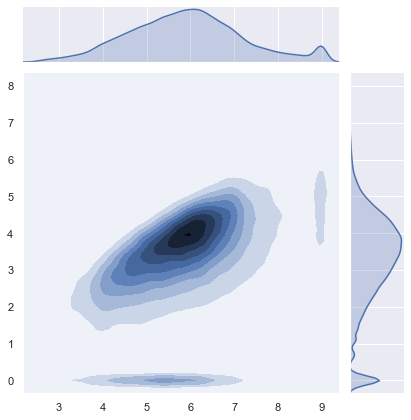

In [226]:
sns.jointplot(
    np.clip(log_scale_followedby, 2, 9), 
    np.clip(log_scale_post_0_likes, 0, 8),
    kind="kde");

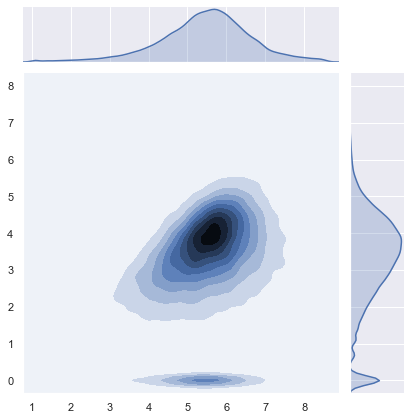

In [227]:
sns.jointplot(
    np.clip(log_scale_follow, 1, 9), 
    np.clip(log_scale_post_0_likes, 0, 8),
    kind="kde");

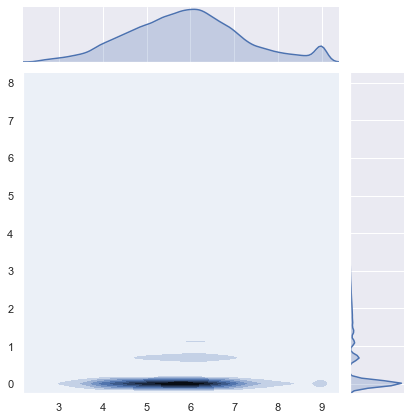

In [228]:
sns.jointplot(
    np.clip(log_scale_followedby, 2, 9), 
    np.clip(log_scale_post_0_comments, 0, 8),
    kind="kde");

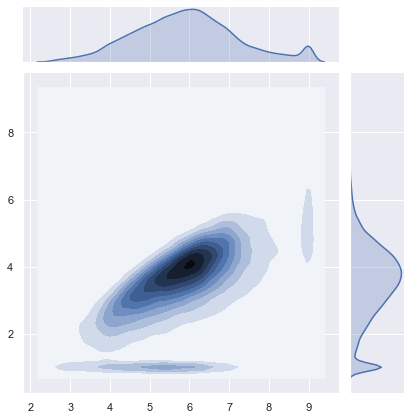

In [255]:
sns.jointplot(
    np.clip(log_scale_followedby, 2, 9), 
    np.clip(log_likes_mean, 1, 9),
    kind="kde");

## profile generation

**Latent space**

In [329]:
def filter_zeroes(df, field):
    zero_chance = df[df[field] == 0].shape[0] / df.shape[0]
    return [df[df[field] != 0], zero_chance]

In [330]:
df = stats.copy()
df.drop(columns=["_id", "id"], inplace=True)
df.head()

,username,followedby,follow,postscount,post_0_comments,post_0_likes,post_1_comments,post_1_likes,post_2_comments,post_2_likes,...,post_7_comments,post_7_likes,post_8_comments,post_8_likes,post_9_comments,post_9_likes,likes_mean,likes_median,comments_mean,comments_median
0,shmkristina,304,742,154,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,marie_vorobeva,517,397,758,3.0,69.0,0.0,57.0,0.0,51.0,...,2.0,67.0,5.0,81.0,5.0,80.0,66.6,66.6,1.8,1.5
2,ann_drd,76,157,37,2.0,29.0,0.0,8.0,0.0,19.0,...,0.0,22.0,0.0,13.0,0.0,11.0,16.6,16.6,0.2,0.0
3,nails.by.kuznetsova,365,865,185,0.0,3.0,0.0,11.0,0.0,13.0,...,0.0,9.0,0.0,9.0,0.0,16.0,11.8,11.8,0.4,0.0
4,dp_kulakovski_ignatova,368,243,80,1.0,49.0,0.0,90.0,2.0,76.0,...,0.0,41.0,2.0,50.0,0.0,46.0,60.6,60.6,1.1,0.5


In [331]:
df = filter_outliers(df, ["followedby", "follow", "postscount"])

df["log_followedby"] = df["followedby"].apply(lambda x:x+1).apply(np.ma.log)
df["log_follow"] = df["follow"].apply(lambda x:x+1).apply(np.ma.log)
df["log_postscount"] = df["postscount"].apply(lambda x:x+1).apply(np.ma.log)
df.drop(columns=["followedby", "follow", "postscount"], inplace=True)

In [332]:
df["likes_sum"] = df[likes_cols].apply(np.sum, axis=1)
df["likes_mean"] = df[likes_cols].apply(np.mean, axis=1)
df["comments_sum"] = df[comments_cols].apply(np.sum, axis=1)
df["comments_mean"] = df[comments_cols].apply(np.mean, axis=1)
df.drop(columns=likes_cols, inplace=True)
df.drop(columns=comments_cols, inplace=True)
print(df.shape)
[df, zero_chance] = filter_zeroes(df, 'likes_mean')
print(df.shape)
df["log_likes_mean"] = df["likes_mean"].apply(lambda x:x+1).apply(np.ma.log)
df["log_comments_mean"] = df["comments_mean"].apply(lambda x:x+1).apply(np.ma.log)

(97851, 10)
(93119, 10)


In [305]:
df.head()

,username,likes_mean,likes_median,comments_mean,comments_median,log_followedby,log_follow,log_postscount,likes_sum,comments_sum,log_likes_mean,log_comments_mean
1,marie_vorobeva,66.6,66.6,1.8,1.5,6.249975,5.986452,6.632002,666.0,18.0,4.213608,1.029619
2,ann_drd,16.6,16.6,0.2,0.0,4.343805,5.062595,3.637586,166.0,2.0,2.867899,0.182322
3,nails.by.kuznetsova,11.8,11.8,0.4,0.0,5.902633,6.763885,5.225747,118.0,4.0,2.549445,0.336472
4,dp_kulakovski_ignatova,60.6,60.6,1.1,0.5,5.910797,5.497168,4.394449,606.0,11.0,4.120662,0.741937
6,evgeniy_400_,323.3,323.3,32.6,31.5,8.165079,7.169350,4.624973,3233.0,326.0,5.781669,3.514526


In [393]:
core = df[["log_followedby", "log_follow", "log_postscount", "log_likes_mean"]].values
core_mean = np.mean(core, axis=0)
core_cov = np.cov(core, rowvar=0)

In [394]:
core_mean

array([5.93778163, 5.50334378, 4.93330762, 3.68370048])

In [395]:
core_cov

array([[1.48911368, 0.61788945, 0.76659012, 0.71974687],
       [0.61788945, 1.06958398, 0.47353374, 0.3087927 ],
       [0.76659012, 0.47353374, 1.73693449, 0.23143598],
       [0.71974687, 0.3087927 , 0.23143598, 0.9307924 ]])

**Followedby to likes model**

In [396]:
from sklearn.linear_model import LinearRegression

followed_likes_model = LinearRegression(normalize=True)
followed_likes_model.fit(df["log_followedby"].values[:, None], df["log_likes_mean"].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

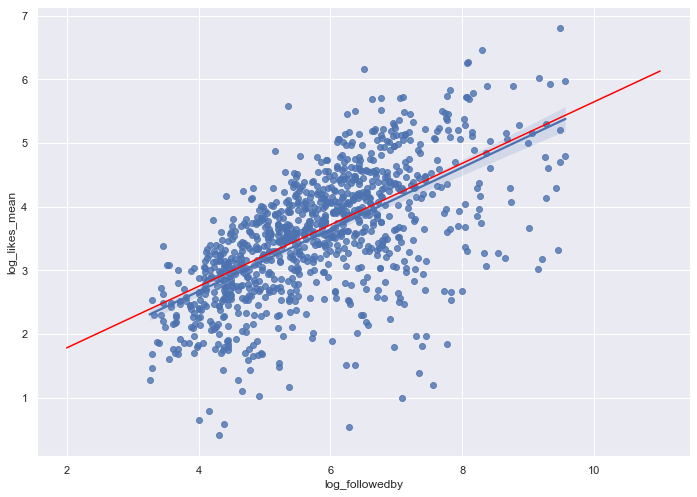

In [397]:
sns.regplot(df["log_followedby"][:1000], df["log_likes_mean"][:1000], fit_reg=True)
x = np.linspace(2, 11, 100)
sns.lineplot(x, followed_likes_model.predict(x[:, None]), color='red');

**Followedby to comments model**

In [339]:
followed_comments_model = LinearRegression(normalize=True)
followed_comments_model.fit(df["log_followedby"].values[:, None], df["log_comments_mean"].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

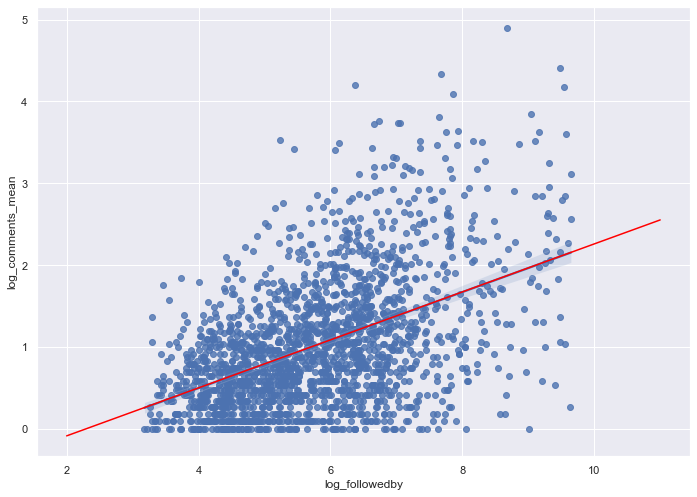

In [340]:
sns.regplot(df["log_followedby"][:2000], df["log_comments_mean"][:2000], fit_reg=True)
x = np.linspace(2, 11, 100)
sns.lineplot(x, followed_comments_model.predict(x[:, None]), color='red');

**Generation**

In [398]:
from scipy.stats import multivariate_normal
from random import *

In [399]:
latent_space = multivariate_normal(mean=core_mean, cov=core_cov)

In [400]:
def generate_new_users(count=1, space=latent_space):
    cols = ["followedby", "follow", "postscount", "likes_mean"]
    df = pd.DataFrame(space.rvs(count), columns=cols)
    
    #df["likes_mean"] = followed_likes_model.predict(df["followedby"].values[:, None])
    df["likes_mean"] = df["likes_mean"].apply(lambda x: 0 if random() <= zero_chance else x)
    df["comments_mean"] = followed_comments_model.predict(df["followedby"].values[:, None])
    return np.exp(df).apply(lambda x:x-1)

In [404]:
generate_new_users(10)

,followedby,follow,postscount,likes_mean,comments_mean
0,105.791425,83.936739,147.159956,25.192633,1.003732
1,1147.578315,107.830424,516.446253,27.581222,3.022188
2,1173.115039,149.697779,333.782821,32.181075,3.048218
3,848.872242,1234.527838,224.914908,15.201177,2.682059
4,743.334128,449.702328,8.186165,87.097896,2.541589
5,1470.956912,320.827676,61.388008,67.996961,3.325794
6,260.654332,150.178265,425.613810,15.581453,1.606198
7,503.134497,1251.096733,300.993117,28.291785,2.159059
8,1198.539027,170.162809,809.712091,74.697919,3.073738
9,1668.458158,1532.180193,210.653629,137.212057,3.488551


**Comparison**

In [405]:
stats.columns

Index(['_id', 'id', 'username', 'followedby', 'follow', 'postscount',
       'post_0_comments', 'post_0_likes', 'post_1_comments', 'post_1_likes',
       'post_2_comments', 'post_2_likes', 'post_3_comments', 'post_3_likes',
       'post_4_comments', 'post_4_likes', 'post_5_comments', 'post_5_likes',
       'post_6_comments', 'post_6_likes', 'post_7_comments', 'post_7_likes',
       'post_8_comments', 'post_8_likes', 'post_9_comments', 'post_9_likes',
       'likes_mean', 'likes_median', 'comments_mean', 'comments_median'],
      dtype='object')

In [406]:
generated_users = generate_new_users(104000)

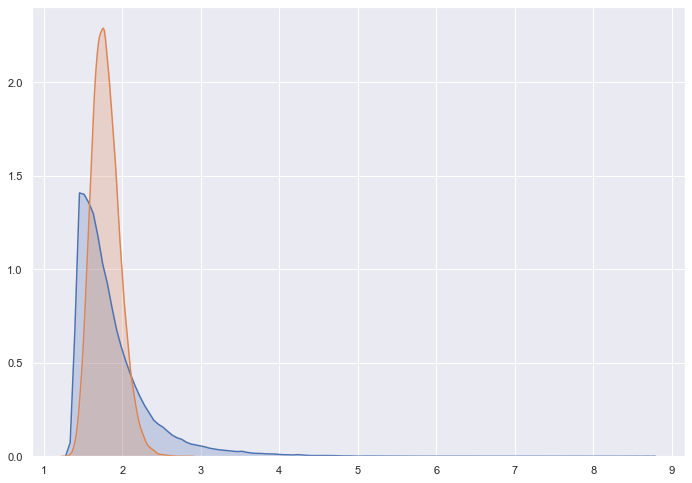

In [421]:
sns.kdeplot(np.ma.log(stats.comments_mean.apply(lambda x:x+4).values), shade=True);
sns.kdeplot(np.ma.log(generated_users.comments_mean.apply(lambda x:x+4).values), shade=True);

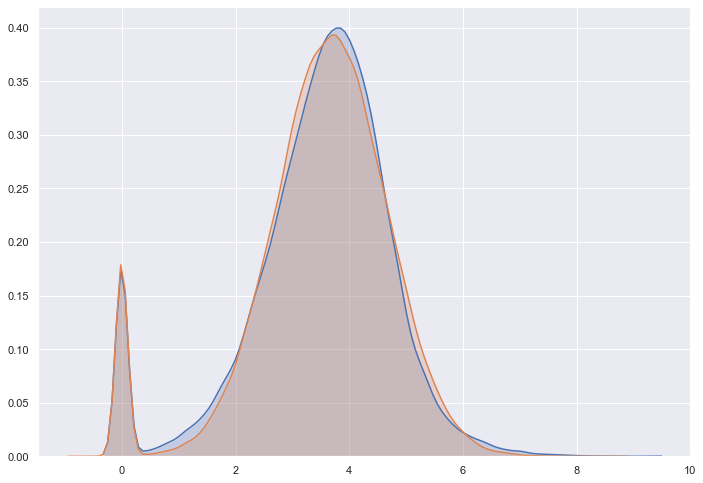

In [408]:
sns.kdeplot(np.ma.log(stats.likes_mean.apply(lambda x:x+1).values), shade=True);
sns.kdeplot(np.ma.log(generated_users.likes_mean.apply(lambda x:x+1).values), shade=True);

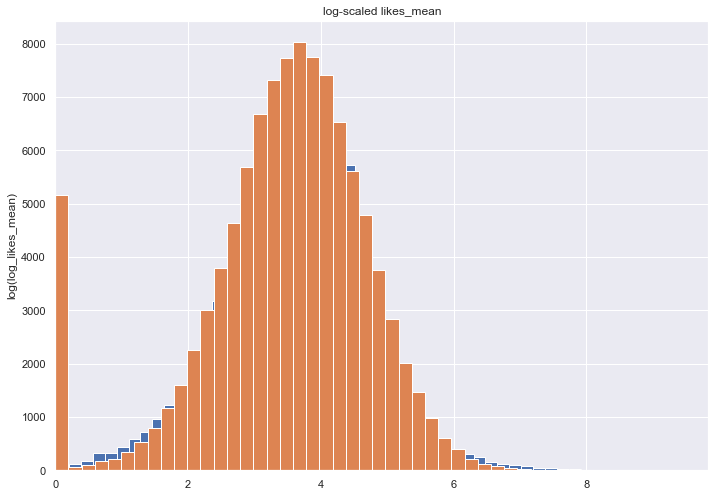

In [413]:
log_likes_mean = np.ma.log(stats.likes_mean.values)
log_likes_mean2 = np.ma.log(generated_users.likes_mean.values)
log_likes_mean.shape
plt.hist(log_likes_mean, bins=64)
plt.hist(log_likes_mean2, bins=64)
plt.title("log-scaled likes_mean")
plt.xlabel('')
plt.ylabel('log(log_likes_mean)')
plt.xlim((0, None));


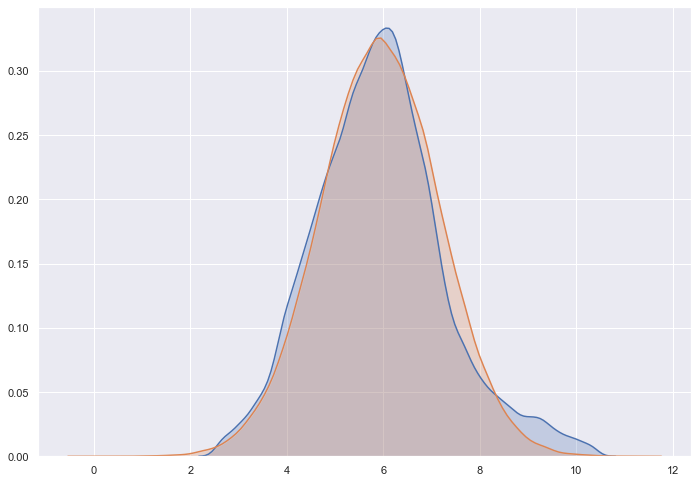

In [414]:
sns.kdeplot(np.ma.log(stats.followedby.values), shade=True);
sns.kdeplot(np.ma.log(generated_users.followedby.values), shade=True);

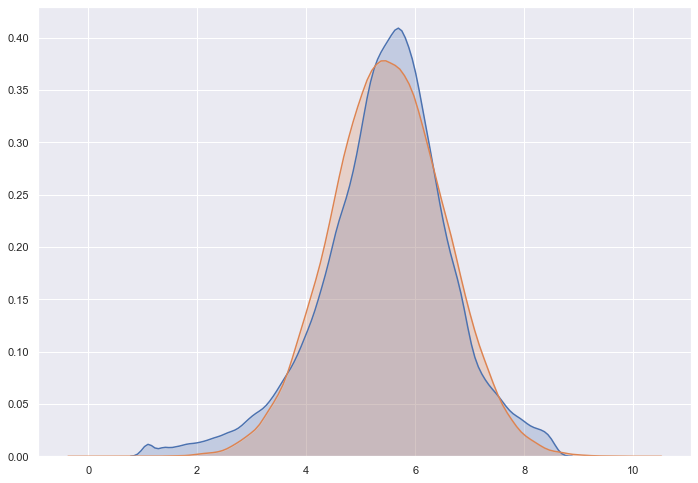

In [415]:
sns.kdeplot(np.ma.log(stats.follow.values), shade=True);
sns.kdeplot(np.ma.log(generated_users.follow.values), shade=True);

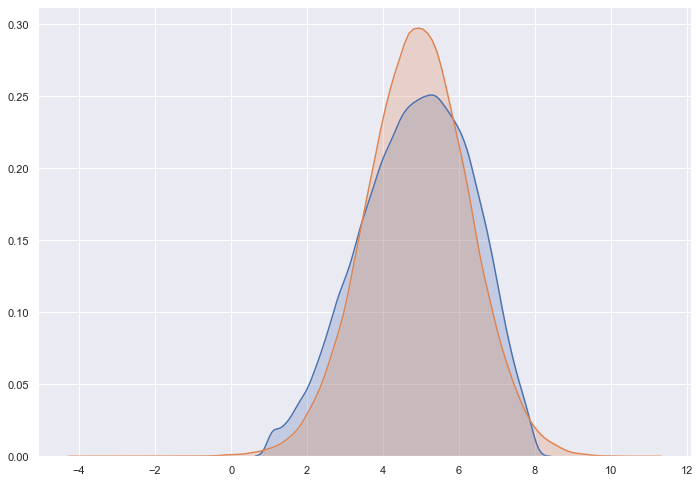

In [416]:
sns.kdeplot(np.ma.log(stats.postscount.values), shade=True);
sns.kdeplot(np.ma.log(generated_users.postscount.values), shade=True);


In [163]:
test = stats[['followedby','likes_mean','likes_median','comments_mean','comments_median']].copy()
from sklearn import cluster
import matplotlib.patches as mpatches
N_CLUSTERS = 7
k_m = cluster.KMeans(n_clusters=N_CLUSTERS, n_init=4)
k_m.fit(test.values)
labels = k_m.labels_
test['cluster'] = labels



from sklearn import mixture
clf = mixture.GaussianMixture(n_components = N_CLUSTERS, covariance_type='full')
cheat = stats[['followedby','likes_mean','likes_median','comments_mean','comments_median']].copy()

clf.fit(cheat.values)
cheat['cluster'] = clf.predict(cheat.values)
#test = test[test['cluster']!=0]

In [164]:
for i in range(0, N_CLUSTERS):
    print(cheat[cheat['cluster'] == i].shape, i)

(40124, 6) 0
(7102, 6) 1
(11759, 6) 2
(26871, 6) 3
(469, 6) 4
(3857, 6) 5
(14562, 6) 6


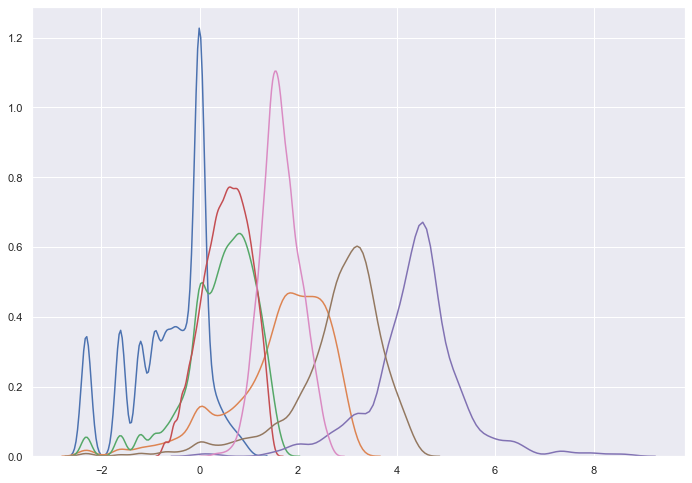

In [165]:
for i in range(0, N_CLUSTERS):
    sns.kdeplot(np.ma.log(cheat[cheat['cluster'] == i].comments_mean.values));

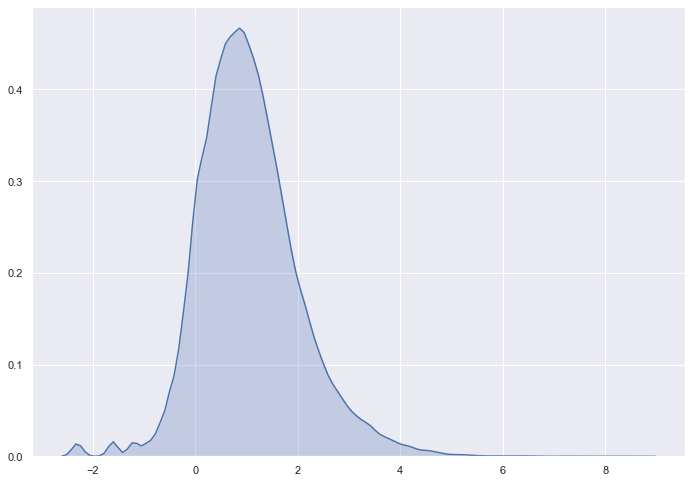

In [167]:
sns.kdeplot(np.ma.log(cheat[(cheat['cluster']!=0)].comments_mean.values), shade=True);

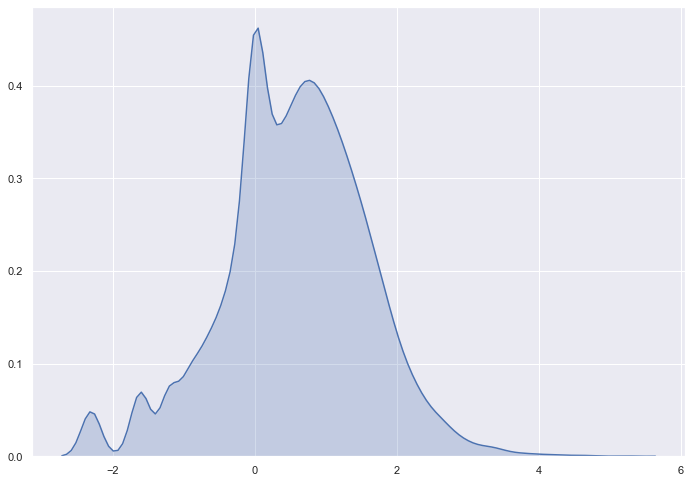

In [380]:
sns.kdeplot(np.ma.log(test[test['cluster']==11].comments_mean.values), shade=True);

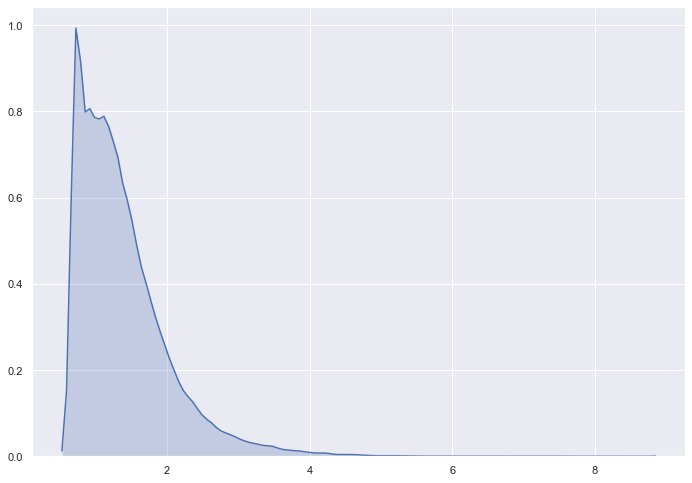

In [234]:
sns.kdeplot(np.ma.log(stats.comments_mean.apply(lambda x: x + 2).values), shade=True);

In [252]:
stats_copy = stats[['followedby','likes_mean','likes_median','comments_mean','comments_median']].copy()

def fix_distribution(a, field):
    small_peak = a[(a[field]<1)]
    gauss_peak = a[(a[field]>=1)]
    return [small_peak, gauss_peak]
    

[a, b] = fix_distribution(stats_copy, 'likes_mean')
print(a.shape)
print(b.shape)

(5312, 5)
(99432, 5)


In [212]:
a['likes_mean'].describe()

count    5312.000000
mean        0.030008
std         0.140457
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.900000
Name: likes_mean, dtype: float64

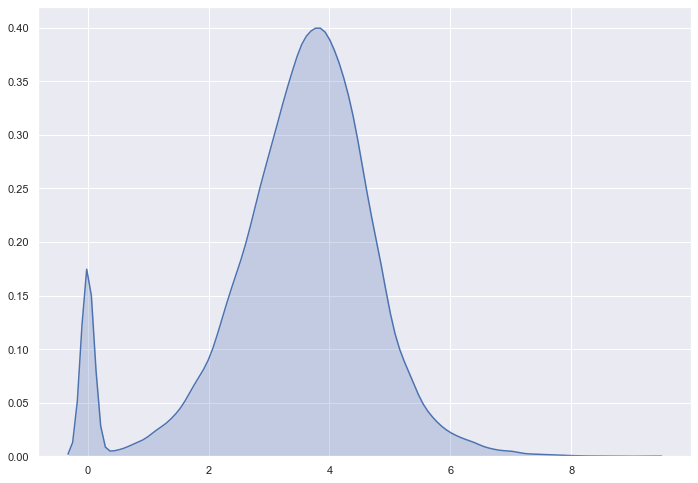

In [417]:
sns.kdeplot(np.ma.log(stats.likes_mean.apply(lambda x: x + 1).values), shade=True);

In [222]:
a.likes_mean.apply(lambda x: x + 1).values

array([1. , 1. , 1. , ..., 1. , 1. , 1.3])